In [104]:
import pyvisa
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
import scipy.special as special
from scipy.signal import find_peaks
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence

In [105]:
N = 50       # number of loops
lc = 3.7e-2*np.pi     # magnetic core length / m
l = 4.7e-2
w = 51e-6 * 4
ur = 50000
u0 = 4* np.pi * 1e-7
u = ur * u0
Ac = l * w   # cross-sectional area / m2
fre = 4      # current frequency
T = 5       # measure time
# R = 1 * 3.6 / 6  # resistance calculate
R = 2
gain = 18.5
samp_rate = 5000
n_sample = samp_rate * T
dt = 1/samp_rate

In [106]:
def test_func(x, a ,b, c):
    return a * np.sin(b *2*np.pi* x + c)

def sin_fit(raw_data, Vset, fre, time_data):
    #x_data = np.linspace(0 , time_mea, len(raw_data))
    x_data = np.array(time_data)
    y_data = np.array(raw_data)
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=[0.5,fre,0])
    # plt.plot(x_data, y_data, '.', label='Data')
    # plt.plot(x_data, test_func(x_data, params[0], params[1],params[2]),label='Fitted function',color = "r")
    # plt.legend(loc='best')
    # plt.show()
    return params, x_data

def off_subtract(Vin,Vpick):
    input_off_mea = np.mean(Vin[1000:5000])
    Vin_sub = Vin - input_off_mea
    pick_off_mea = np.mean(Vpick[1000:5000])
    Vpick_sub = Vpick - pick_off_mea
    return Vin_sub, Vpick_sub

In [107]:
fname = "C:\\Users\\CeNTREX\\Documents\\GitHub\\new_cavity\\mu_minorloop_4_19_2024.hdf"
Vin = []
Vpick = []
Vin_used = []
Vpick_used = []
#Vamp = [0.025,0.05,0.1,0.15,0.2,0.3,0.5,0.7,0.8,1,1.5,2,3,4,5]
Vamp = [9]
with h5py.File(fname, "a") as f:
    for i in Vamp:
        dset = f[f"{i}Vpp"]
        Vin.append(dset[0])
        Vpick.append(dset[1])
        
time_stamp = np.linspace(0,T,len(Vin[0]))


In [108]:
time_mea = []
Vin_mea  = []
Vpick_mea = []
for i in range(len(Vamp)):
    Vin_used, Vpick_used = off_subtract(Vin[i],Vpick[i])
    pos_peaks,_ = find_peaks(Vpick_used,distance=1000, height = max(Vpick_used)*0.9)
    time_mea.append(time_stamp[pos_peaks[0]:-1])
    Vin_mea.append(Vin_used[pos_peaks[0]:-1])
    Vpick_mea.append(Vpick_used[pos_peaks[0]:-1])


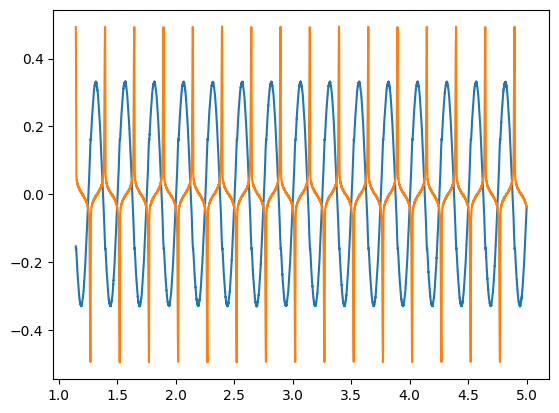

In [109]:
plt.plot(time_mea[-1],Vin_mea[-1])
plt.plot(time_mea[-1],Vpick_mea[-1])

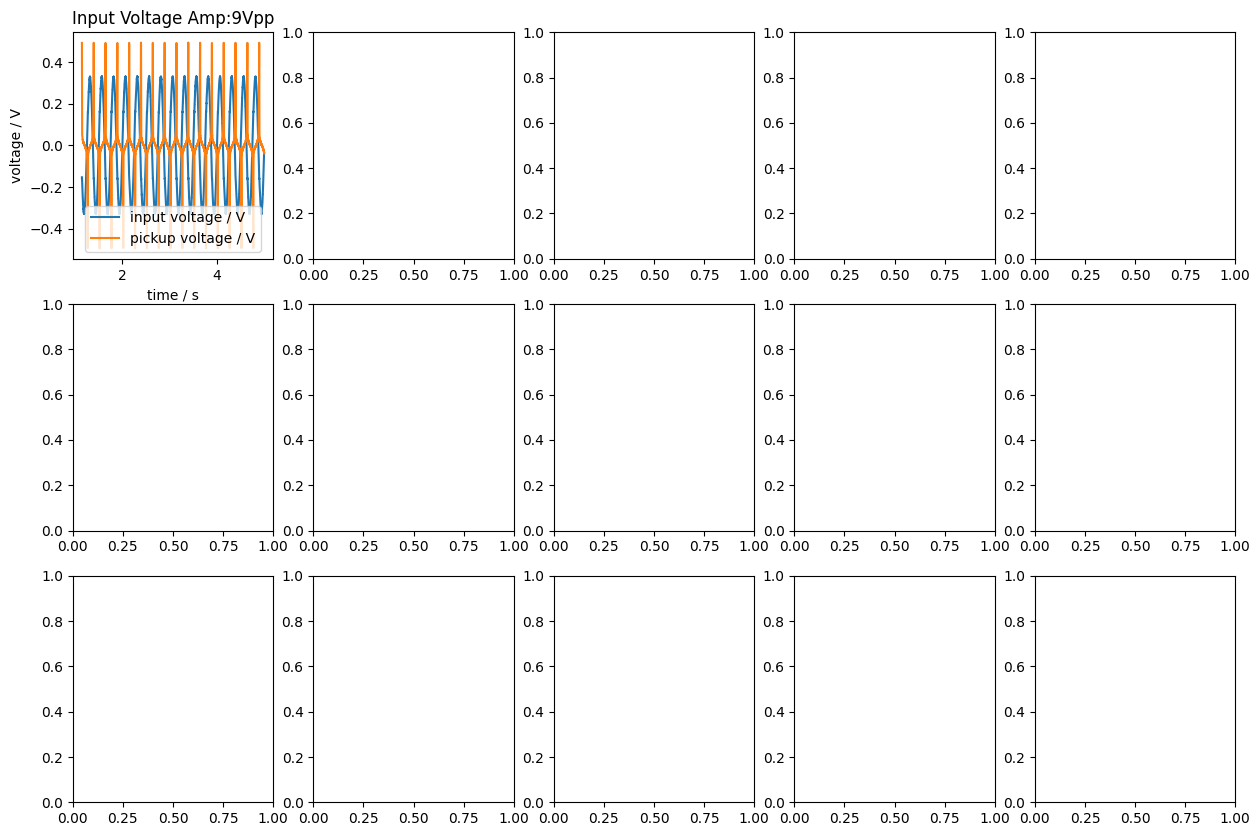

In [110]:
fig, ax = plt.subplots(3,5,figsize=(15, 10))
for i in range(len(Vamp)):
    if i < 5 :
        ax[0,i].plot(time_mea[i],Vin_mea[i], label = "input voltage / V")
        ax[0,i].plot(time_mea[i],Vpick_mea[i], label = "pickup voltage / V")
        ax[0,i].set_title("Input Voltage Amp:" + str(Vamp[i])+"Vpp")
        ax[0,i].set_xlabel("time / s")
        ax[0,i].set_ylabel("voltage / V")
        ax[0,i].legend()
    elif i < 10:
        ax[1,i-5].plot(time_mea[i],Vin_mea[i], label = "input voltage / V")
        ax[1,i-5].plot(time_mea[i],Vpick_mea[i], label = "pickup voltage / V")
        ax[1,i-5].set_title("Input Voltage Amp:" + str(Vamp[i])+"Vpp")
        ax[1,i-5].set_xlabel("time / s")
        ax[1,i-5].set_ylabel("voltage / V")
        ax[1,i-5].legend()
    else:
        ax[2,i-10].plot(time_mea[i],Vin_mea[i], label = "input voltage / V")
        ax[2,i-10].plot(time_mea[i],Vpick_mea[i], label = "pickup voltage / V")
        ax[2,i-10].set_title("Input Voltage Amp:" + str(Vamp[i])+"Vpp")
        ax[2,i-10].set_xlabel("time / s")
        ax[2,i-10].set_ylabel("voltage / V")
        ax[2,i-10].legend()


In [111]:
amp_fit = []
fre_fit = []
phase_fit = []
V_SGamp = []
for i in range(len(Vamp)):
    param,x = sin_fit(Vin_mea[i],Vamp[i],4,time_mea[i])
    amp_fit.append(param[0])
    fre_fit.append(param[1])
    phase_fit.append(param[2])
    if param[0] > 0:
        V_SGamp.append((2 * Vamp[i] - 2*abs(param[0]))/2)
    else:
        V_SGamp.append((-1* (2 * Vamp[i] - 2*abs(param[0])))/2)

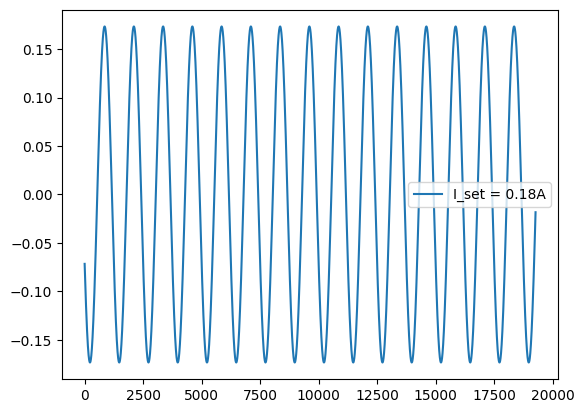

In [112]:
I = []
I_set = np.array(Vamp)/50
I_SGamp = np.array(V_SGamp)/50
for i in range(len(Vamp)):
    V_SG = test_func(time_mea[i], V_SGamp[i], param[1],param[2])
    I.append(V_SG /50)
    plt.plot(I[i], label  = "I_set = "+ str(I_set[i]) + "A")
    plt.legend()


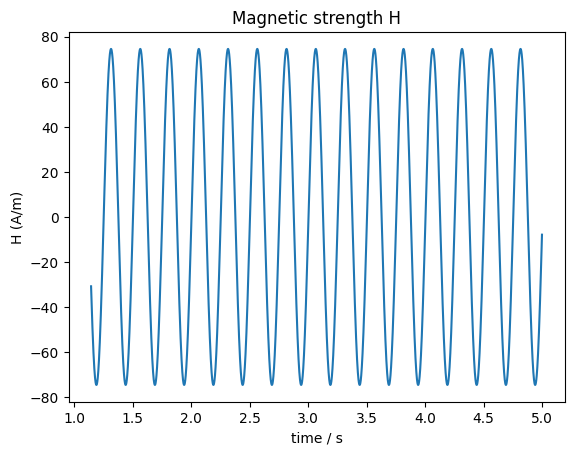

In [113]:
H = []
B = []
B_int = []
peaks_find = []
mean = []
for i in range(len(Vamp)):
    H.append(np.array(I[i]) * N / lc)         # Magnetic field strength
    plt.plot(time_mea[i],H[i])
    plt.xlabel("time / s")
    plt.ylabel("H (A/m)")
    plt.title("Magnetic strength H")

for i in range(len(Vamp)):
    dB = -1* np.array(Vpick_mea[i])/Ac/N/gain
    Bini = [0]
    for a in dB:
        Bini.append(Bini[-1] + ( a - 0.0) * dt )
    B.append(Bini[1:])

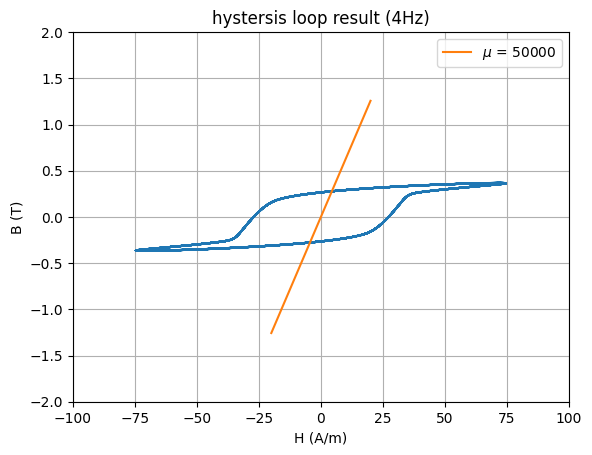

In [117]:
H_line = np.linspace(-20,20,12)
B_the = H_line * u
B_amped = []
for i in range(len(Vamp)):
    #plt.plot(H[11-i],B[11-i]-(max(B[11-i])+min(B[11-i]))/2,'-', label = "I amp = " + str(Vamp[11-i]/50)+ "A")
    plt.plot(H[len(Vamp)-i-1],B[len(Vamp)-i-1]-(max(B[len(Vamp)-i-1])+min(B[len(Vamp)-i-1]))/2,'-')
plt.plot(H_line,B_the, label = r"$\mu$ = 50000")
plt.xlim([-100,100])
plt.ylim([-2,2])
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("hystersis loop result (4Hz)")
plt.grid(True)
plt.legend()

In [115]:
H_line = np.linspace(-10,10,12)
B_the = H_line * u
B_amped = []
plt_num = 2
for i in range(plt_num+1):
    plt.plot(H[plt_num-i],B[plt_num-i]-(max(B[plt_num-i])+min(B[plt_num-i]))/2,'-', label = "I amp = " + str(Vamp[plt_num-i]/50))
plt.plot(H_line,B_the, label = r"$\mu$ = 50000")
plt.xlim([min(H[plt_num]*1.5),max(H[plt_num])*1.5])
plt.ylim([min(B[plt_num])*1.5,max(B[plt_num])*1.5])
#plt.ylim([-2,2])
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("hystersis loop result (4Hz)")
plt.grid(True)
plt.legend()

IndexError: list index out of range

In [116]:
for i in [14,13]:
    plt.plot(H[i],B[i]-(max(B[i])+min(B[i]))/2,'-', label = "I amp = " + str(Vamp[i]/50))

plt.grid(True)

IndexError: list index out of range

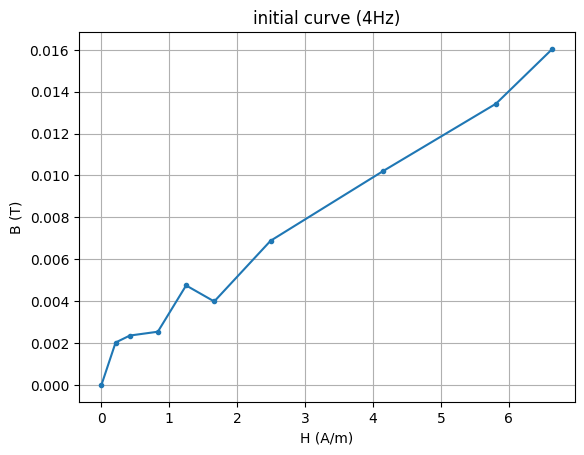

In [ ]:
H_vertice = []
B_vertice = []
H_vertice.append(0)
B_vertice.append(0)
for i in range(len(Vamp)):
    H_vertice.append((max(H[i])-min(H[i]))/2)
    B_vertice.append((max(B[i])-min(B[i]))/2)
plt.plot(H_vertice[0:10],B_vertice[0:10],'.-')
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("initial curve (4Hz)")
plt.grid(True)

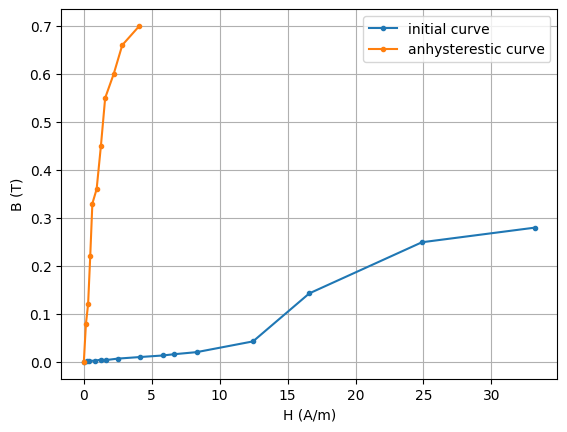

In [ ]:
off =[0,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,0.9,1.3,2]
H_off = np.array(off) / (50+R)  * 19 /lc
B_settle = [0,0.08,0.12,0.22,0.33,0.36,0.45,0.55,0.6,0.66,0.7,0.73]
m = np.s_[0:-1]
plt.plot(H_vertice[m],B_vertice[m],'.-', label = "initial curve")
plt.plot(H_off[m],B_settle[m],'.-', label = "anhysterestic curve")
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.legend()
plt.grid(True)

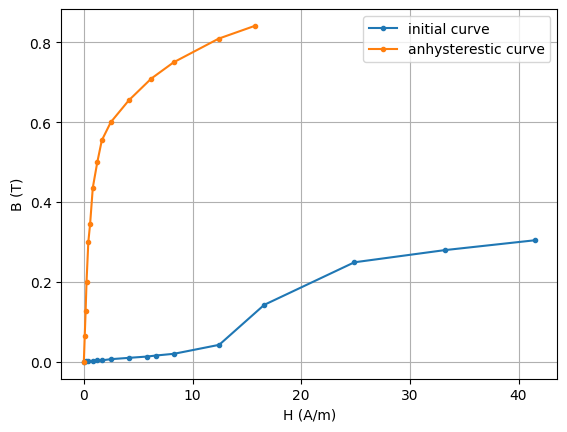

In [ ]:
off = [0,0.01,0.02,0.03,0.05,0.07,0.1,0.15,0.2,0.3,0.5,0.75,1,1.5,1.9]
H_off = np.array(off) / (50+R) * N /lc
B_settle = np.array([0,0.07,0.14,0.22,0.33,0.38,0.48,0.55,0.61,0.66,0.72,0.78,0.825,0.89,0.925])/16.5*15
plt.plot(H_vertice,B_vertice,'.-', label = "initial curve")
plt.plot(H_off,B_settle,'.-', label = "anhysterestic curve")
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.legend()
plt.grid(True)

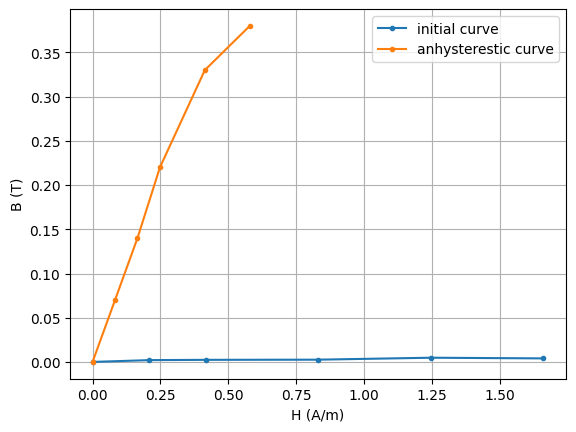

In [ ]:
m = np.s_[0:6]
off = [0,0.01,0.02,0.03,0.05,0.07,0.1,0.15,0.2,0.3,0.5,0.75,1,1.5,1.9]
H_off = np.array(off) / (50+R)* N /lc
B_settle = [0,0.07,0.14,0.22,0.33,0.38,0.48,0.55,0.61,0.66,0.72,0.77,0.81,0.87,0.925]
plt.plot(H_vertice[m],B_vertice[m],'.-', label = "initial curve")
plt.plot(H_off[m],B_settle[m],'.-', label = "anhysterestic curve")
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.legend()
plt.grid(True)